Trong notebook này, chúng ta sẽ xây dựng mô hình đánh giá chất lượng các khóa học trong MOOCCubeX.





# Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download and import libraries

In [1]:
!pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 8.7 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17395 sha256=563a5a696a3cedb0dad79642b52c06b5b8673dd868e0676e1698ded6dc9508a4
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import warnings
import json
import shutil
import pickle
import time
from googletrans import Translator

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

In [4]:
from google.colab import files

In [5]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers
from keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Bidirectional, LSTM, concatenate
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

In [6]:
warnings.filterwarnings('ignore')

# Download dataset

In [ ]:
!mkdir -p Input Output

In [ ]:
# # Download toàn bộ dataset
# %%bash

# mkdir -p Input/entities Input/relations
# for filename in entities/reply.json entities/video.json entities/comment.json entities/course.json entities/other.json entities/paper.json entities/problem.json entities/school.json entities/teacher.json entities/user.json entities/concept.json relations/course-school.txt relations/course-teacher.txt relations/user-comment.txt relations/video_id-ccid.txt relations/comment-reply.txt relations/concept-other.txt relations/course-comment.txt relations/concept-video.txt relations/exercise-problem.txt relations/user-reply.txt relations/concept-comment.txt relations/concept-paper.txt relations/concept-problem.txt relations/concept-reply.json relations/course-field.json relations/reply-reply.txt relations/user-problem.json relations/user-video.json relations/user-xiaomu.json prerequisites/psy.json prerequisites/cs.json prerequisites/math.json; do
#     echo "Downloading ${filename} ..."
#     wget -cq "https://lfs.aminer.cn/misc/moocdata/data/mooccube2/${filename}" -O ${filename}
# done

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Process is interrupted.


In [ ]:
%%bash

mkdir -p Input/entities Input/relations
for filename in entities/course.json; do
    echo "Downloading ${filename} ..."
    wget -cq "https://lfs.aminer.cn/misc/moocdata/data/mooccube2/${filename}" -O "/content/drive/MyDrive/CS313_Mai_modelling_course_quality/Input/${filename}"
done

In [ ]:
source_path = 'Input/'
des_path = 'Output/'

# Read and prepare dataset

In [ ]:
df_course_rate = pd.read_csv("/content/drive/MyDrive/CS313_Mai_modelling_course_quality/Input/course_criterion_labelled.csv",index_col=0)

In [ ]:
df_course_rate

,course_id,sentiment_index,school_ranking,teacher_rate,completion_rate,video_engagement,exercise_engagement,cluster,final_rank
0,C_584313,3,5.0,2.0,1,1.0,1,0,2.0
1,C_584329,3,5.0,2.0,1,1.0,1,0,2.0
2,C_584381,3,5.0,2.0,1,1.0,1,0,2.0
3,C_597208,3,5.0,4.0,1,1.0,1,0,2.0
4,C_597225,3,4.0,1.0,1,1.0,1,0,2.0
...,...,...,...,...,...,...,...,...,...
3776,C_2338076,3,5.0,2.0,1,1.0,1,0,2.0
3777,C_2341259,3,5.0,1.5,1,1.0,1,0,2.0
3778,C_2337996,3,5.0,2.0,1,1.0,1,0,2.0
3779,C_1945689,3,1.0,5.0,3,3.0,5,1,5.0


In [ ]:
df_course = pd.read_json('/content/drive/MyDrive/CS313_Mai_modelling_course_quality/Input/entities/course.json', lines=True)

In [ ]:
df_course

,id,name,field,prerequisites,about,resource
0,C_584313,《资治通鉴》导读,"[历史学, 中国语言文学]",,通过老师导读，同学们可深入这一经典文本内部，得以纵览千年历史，提升国学素养，体味人生智慧。,"[{'titles': ['第一课 导论与三家分晋', '导论', '导论'], 'reso..."
1,C_584329,微积分——极限理论与一元函数,"[应用经济学, 数学, 物理学, 理论经济学]",,本课程是理工科的一门数学基础课，系统、全面地介绍了一元函数微积分学。课程既保持了数学的严谨和...,"[{'titles': ['序言', '序言', '序言'], 'resource_id':..."
2,C_584381,新闻摄影,"[艺术学, 新闻传播学]",,掌握基本的摄影技能，了解图片新闻的工作方式，训练对生活的观察和热爱，发展对图像的审美和批评能...,"[{'titles': ['第一章 绪论', '第一讲 引言1', '引言1'], 'res..."
3,C_597208,数据挖掘：理论与算法,[计算机科学与技术],,最有趣的理论+最有用的算法=不得不学的数据科学。,"[{'titles': ['走进数据科学：博大精深，美不胜收', '整装待发', 'Vide..."
4,C_597225,大学计算机,[],,大学计算机课程将以计算思维为导向，以计算机原理、概念为基础，以新技术新方法为牵引，以创新思维...,"[{'titles': ['第1周： 基于计算机的问题求解', '课程介绍', '开篇'],..."
...,...,...,...,...,...,...
3776,C_2338076,（疾风计划）软件工程,[],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第1章 初识软件工程 ', '1.1 软件无处不在 ', '讲课..."
3777,C_2341259,（疾风计划）面向对象程序设计（C++）,[],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第一讲 课程简介与编程环境', '1.0 课程定位、教学内容',..."
3778,C_2337996,（疾风计划）数据结构(下),[],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第零章 ', '选课之前', '宣传片'], 'resourc..."
3779,C_1945689,机器学习训练营,[],,清华张敏老师带你12周掌握机器学习！8大经典算法 +7大实训 + 直播点评 + 博士助教+云...,"[{'titles': ['序-开营仪式及学习课件', None, '1.1_初识机器学习'..."


In [ ]:
# Đổi tên cột 'id' trong df_course thành 'course_id'
df_course = df_course.rename(columns={'id': 'course_id'})

# Kết hợp df_course và df_course_rate dựa trên 'course_id'
df = pd.merge(df_course, df_course_rate, on='course_id')

df

,course_id,name,field,prerequisites,about,resource,sentiment_index,school_ranking,teacher_rate,completion_rate,video_engagement,exercise_engagement,cluster,final_rank
0,C_584313,《资治通鉴》导读,"[历史学, 中国语言文学]",,通过老师导读，同学们可深入这一经典文本内部，得以纵览千年历史，提升国学素养，体味人生智慧。,"[{'titles': ['第一课 导论与三家分晋', '导论', '导论'], 'reso...",3,5.0,2.0,1,1.0,1,0,2.0
1,C_584329,微积分——极限理论与一元函数,"[应用经济学, 数学, 物理学, 理论经济学]",,本课程是理工科的一门数学基础课，系统、全面地介绍了一元函数微积分学。课程既保持了数学的严谨和...,"[{'titles': ['序言', '序言', '序言'], 'resource_id':...",3,5.0,2.0,1,1.0,1,0,2.0
2,C_584381,新闻摄影,"[艺术学, 新闻传播学]",,掌握基本的摄影技能，了解图片新闻的工作方式，训练对生活的观察和热爱，发展对图像的审美和批评能...,"[{'titles': ['第一章 绪论', '第一讲 引言1', '引言1'], 'res...",3,5.0,2.0,1,1.0,1,0,2.0
3,C_597208,数据挖掘：理论与算法,[计算机科学与技术],,最有趣的理论+最有用的算法=不得不学的数据科学。,"[{'titles': ['走进数据科学：博大精深，美不胜收', '整装待发', 'Vide...",3,5.0,4.0,1,1.0,1,0,2.0
4,C_597225,大学计算机,[],,大学计算机课程将以计算思维为导向，以计算机原理、概念为基础，以新技术新方法为牵引，以创新思维...,"[{'titles': ['第1周： 基于计算机的问题求解', '课程介绍', '开篇'],...",3,4.0,1.0,1,1.0,1,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,C_2338076,（疾风计划）软件工程,[],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第1章 初识软件工程 ', '1.1 软件无处不在 ', '讲课...",3,5.0,2.0,1,1.0,1,0,2.0
3777,C_2341259,（疾风计划）面向对象程序设计（C++）,[],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第一讲 课程简介与编程环境', '1.0 课程定位、教学内容',...",3,5.0,1.5,1,1.0,1,0,2.0
3778,C_2337996,（疾风计划）数据结构(下),[],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第零章 ', '选课之前', '宣传片'], 'resourc...",3,5.0,2.0,1,1.0,1,0,2.0
3779,C_1945689,机器学习训练营,[],,清华张敏老师带你12周掌握机器学习！8大经典算法 +7大实训 + 直播点评 + 博士助教+云...,"[{'titles': ['序-开营仪式及学习课件', None, '1.1_初识机器学习'...",3,1.0,5.0,3,3.0,5,1,5.0


# Split dataset

In [ ]:
# Chia tập train test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# # Lưu tập train test
# df_train.to_csv('/content/drive/MyDrive/CS313_Mai_modelling_course_quality/Input/course_quality_train.csv', index=False)
# df_test.to_csv('/content/drive/MyDrive/CS313_Mai_modelling_course_quality/Input/course_quality_test.csv', index=False)

In [ ]:
X_train = df_train.iloc[:, :-1]
X_test = df_test.iloc[:, :-1]

y_train = df_train.iloc[:, -1]
y_test = df_test.iloc[:, -1]

# Build model

Notes:
* 2 features = school_ranking +	teacher_rate
* 3 features = school_ranking	+ teacher_rate + about

# DL model with 3 features

Pipeline:

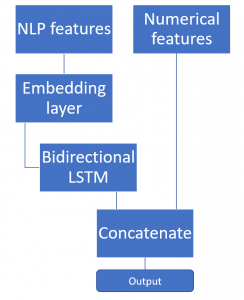

In [ ]:
X_text_train = X_train['about']
X_num_train = X_train[['school_ranking', 'teacher_rate']]
X_text_test = X_test['about']
X_num_test = X_test[['school_ranking', 'teacher_rate']]

In [ ]:
X_text_train = pd.read_csv('/content/drive/MyDrive/CS313_Mai_modelling_course_quality/Input/X_text_train.csv')

In [ ]:
X_text_train

,about
0,"There are a large number of social, ethics and..."
1,"Focusing on the topic of circular economy, wit..."
2,"As a medical student, do you know the characte..."
3,Cancers severely affect human health. With an ...
4,"To understand the law of wealth circulation, e..."
...,...
3019,This course is aimed at the ideological and mo...
3020,"In ancient times, the use of fire made humans ..."
3021,China's modern history is the closest history ...
3022,In addition to the teaching content of the out...


In [ ]:
X_text_test = pd.read_csv('/content/drive/MyDrive/CS313_Mai_modelling_course_quality/Input/X_text_test.csv')

In [ ]:
X_text_test

,about
0,University physics is a basic course for under...
1,The 21st century is the era of digital informa...
2,Chinese Degree and Graduate Education Society ...
3,"Hello, everyone. We are the thermal teaching t..."
4,This course tries to start with Japan's spirit...
...,...
752,We will explain the profound but in -depth mec...
753,"Due to COVID-19, the orientation for non-degre..."
754,Dental Anatomy and Physiology mainly studies t...
755,In order to meet the needs of cultivating appl...


In [ ]:
is_null = X_text_train.isnull()

print(f"Số lượng dòng null: {is_null.sum()}")

if is_null.sum() > 0:
    print("Chỉ mục của các dòng null:")
    print(is_null[is_null == True].index)

Số lượng dòng null: 2
Chỉ mục của các dòng null:
Index([1830, 1711], dtype='int64')


In [ ]:
# Khởi tạo Translator
translator = Translator()

def translate_text(text):
    # Kiểm tra xem text có phải là None hoặc chỉ chứa khoảng trắng
    if text is None or text.strip() == "":
        return ""

    # Phát hiện ngôn ngữ của văn bản
    detected_lang = translator.detect(text).lang

    # Nếu văn bản là tiếng Trung, dịch nó sang tiếng Anh
    if detected_lang is not 'en':
        # Thêm một khoảng trễ 1 giây giữa các yêu cầu dịch
        time.sleep(1)
        return translator.translate(text, src=detected_lang, dest='en').text
    # Nếu không, giữ nguyên văn bản
    else:
        return text

# Dịch cột 'about' trong X_text_train từ tiếng Trung sang tiếng Anh
X_text_train = X_text_train.apply(translate_text)

In [ ]:
X_text_train.to_csv('X_text_train.csv', index=False)

In [ ]:
# Khởi tạo Translator
translator = Translator()

def translate_text(text):
    # Kiểm tra xem text có phải là None hoặc chỉ chứa khoảng trắng
    if text is None or text.strip() == "":
        return ""

    # Phát hiện ngôn ngữ của văn bản
    detected_lang = translator.detect(text).lang

    # Nếu văn bản là tiếng Trung, dịch nó sang tiếng Anh
    if detected_lang is not 'en':
        # Thêm một khoảng trễ 1 giây giữa các yêu cầu dịch
        time.sleep(1)
        return translator.translate(text, src=detected_lang, dest='en').text
    # Nếu không, giữ nguyên văn bản
    else:
        return text

# Dịch cột 'about' trong X_text_test từ tiếng Trung sang tiếng Anh
X_text_test = X_text_test.apply(translate_text)

In [ ]:
X_text_test.to_csv('/content/drive/MyDrive/CS313_Mai_modelling_course_quality/Input/X_text_test.csv', index=False)

In [ ]:
X_text_train['about'] = X_text_train['about'].fillna('')
X_text_test['about'] = X_text_test['about'].fillna('')

In [ ]:
embedding_size = 50  # Kích thước của không gian nhúng
classifier_neurons = 128  # Số lượng neurons trong lớp Dense

In [ ]:
# Khởi tạo Tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")

tokenizer.fit_on_texts(X_text_train['about'])

In [ ]:
# Chuyển đổi từng câu thành chuỗi các số nguyên
X_text_train_sequences = tokenizer.texts_to_sequences(X_text_train['about'])
X_text_test_sequences = tokenizer.texts_to_sequences(X_text_test['about'])

In [ ]:
lengths = [len(seq) for seq in X_text_train_sequences]

seq_length = max(lengths)

In [ ]:
# Thêm padding để đảm bảo tất cả các chuỗi có cùng độ dài
X_text_train = pad_sequences(X_text_train_sequences, maxlen=seq_length, padding='post')
X_text_test = pad_sequences(X_text_test_sequences, maxlen=seq_length, padding='post')

In [ ]:
# Cập nhật input_dim trong lớp Embedding để phù hợp với kích thước của bộ từ điển
vocab_size = len(tokenizer.word_index) + 1  # +1 cho từ không xác định

In [ ]:
# Định nghĩa mô hình
nlp_input = Input(shape=(seq_length,), name='nlp_input')
meta_input = Input(shape=(2,), name='meta_input')
emb = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=seq_length)(nlp_input)
nlp_out = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01)))(emb)
x = concatenate([nlp_out, meta_input])
x = Dense(classifier_neurons, activation='relu')(x)
x = Dense(5, activation='sigmoid')(x)
model = Model(inputs=[nlp_input , meta_input], outputs=[x])

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.4 MB/s eta 0:00:00


In [ ]:
import tensorflow_addons as tfa
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/CS313_Mai_modelling_course_quality/Output/best_DL_3_model',
                             monitor='val_f1_score',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

callbacks_list = [checkpoint]

In [ ]:
# Biên dịch mô hình
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        tfa.metrics.F1Score(num_classes=5, average='macro', name='f1_score'),
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ],
    run_eagerly=True
)

In [ ]:
from keras.utils import to_categorical

# Chuyển đổi y_train thành dạng mã hóa one-hot
y_train = to_categorical(y_train - 1, num_classes=5)
y_test = to_categorical(y_test - 1, num_classes=5)

In [ ]:
y_train

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
y_test

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
# Huấn luyện mô hình
model.fit([X_text_train, X_num_train], y_train, epochs=32, batch_size=64, validation_data=([X_text_test, X_num_test], y_test), callbacks=callbacks_list)

Epoch 1/32
 2/48 [>.............................] - ETA: 6:38 - loss: 0.3179 - f1_score: 0.8316 - accuracy: 0.8672 - precision: 0.5020 - recall: 0.9844

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5158, in <genexpr>
    output_ta_t = tuple(  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


48/48 [==============================] - ETA: 0s - loss: 0.2709 - f1_score: 0.8407 - accuracy: 0.9084 - precision: 0.5459 - recall: 0.9868
Epoch 1: val_f1_score improved from -inf to 0.54451, saving model to /content/drive/MyDrive/CS313_Mai_modelling_course_quality/Output/best_DL_3_model
48/48 [==============================] - 484s 10s/step - loss: 0.2709 - f1_score: 0.8407 - accuracy: 0.9084 - precision: 0.5459 - recall: 0.9868 - val_loss: 0.8931 - val_f1_score: 0.5445 - val_accuracy: 0.7239 - val_precision: 0.5131 - val_recall: 0.8824
Epoch 2/32
48/48 [==============================] - ETA: 0s - loss: 0.2407 - f1_score: 0.8591 - accuracy: 0.9173 - precision: 0.5586 - recall: 0.9864
Epoch 2: val_f1_score improved from 0.54451 to 0.57185, saving model to /content/drive/MyDrive/CS313_Mai_modelling_course_quality/Output/best_DL_3_model
48/48 [==============================] - 471s 10s/step - loss: 0.2407 - f1_score: 0.8591 - accuracy: 0.9173 - precision: 0.5586 - recall: 0.9864 - val_lo

In [ ]:
model.save('/content/drive/MyDrive/CS313_Mai_modelling_course_quality/Output/DL_3_model')

# Evaluate

In [ ]:
# Tải mô hình đã lưu
model = tf.keras.models.load_model('/content/drive/MyDrive/CS313_Mai_modelling_course_quality/Output/best_DL_3_model')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [ ]:
# Dự đoán nhãn của tập dữ liệu kiểm tra
y_pred = model.predict([X_text_test, X_num_test])

24/24 [==============================] - 7s 245ms/step


In [ ]:
# Chuyển đổi dự đoán từ dạng one-hot về dạng nhãn
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

In [ ]:
# In báo cáo phân loại
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91       261
           1       0.80      0.87      0.83       244
           2       0.46      0.28      0.35        92
           3       0.38      0.33      0.35        92
           4       0.41      0.60      0.49        68

    accuracy                           0.72       757
   macro avg       0.59      0.60      0.59       757
weighted avg       0.71      0.72      0.71       757



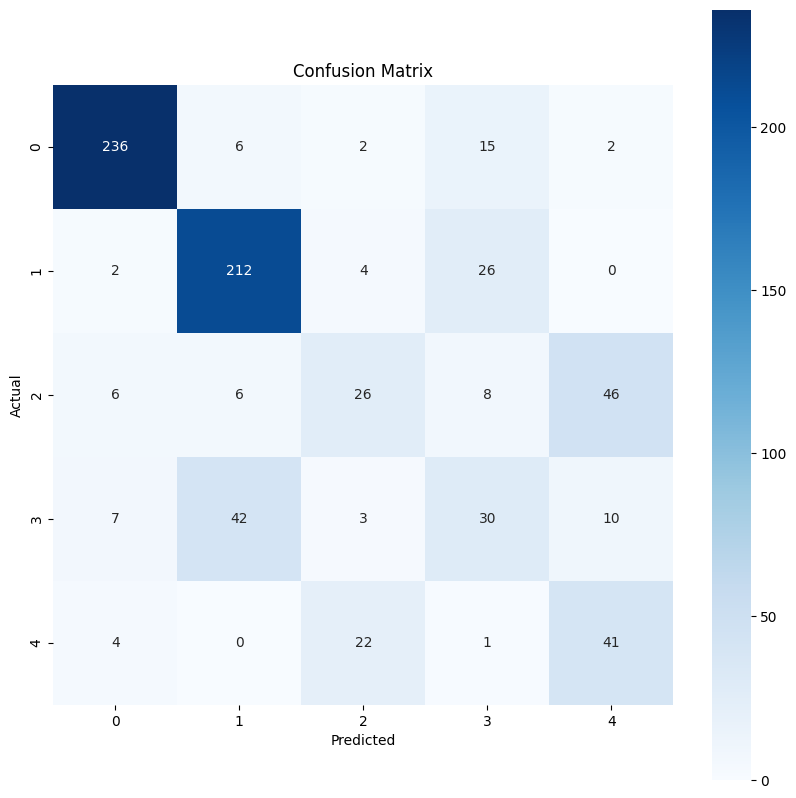

In [ ]:
# Vẽ biểu đồ confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt=".0f", square=True, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()